<a href="https://colab.research.google.com/github/Nawyahsree/FFML_Project_and_labs/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-06-05 06:07:04--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.165.102.31, 3.165.102.36, 3.165.102.62, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.165.102.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   292MB/s    in 0.2s    

2024-06-05 06:07:04 (292 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


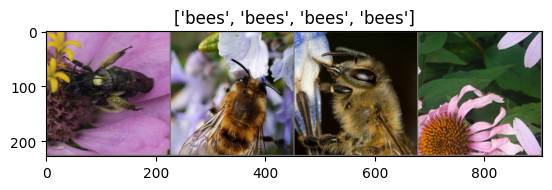

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5112 Acc: 0.7418

Epoch 1/4
----------
Loss: 0.6247 Acc: 0.7992

Epoch 2/4
----------
Loss: 0.4133 Acc: 0.8566

Epoch 3/4
----------
Loss: 0.5660 Acc: 0.7910

Epoch 4/4
----------
Loss: 0.6407 Acc: 0.7910



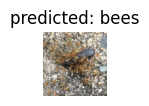

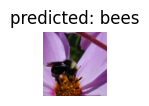

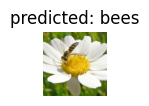

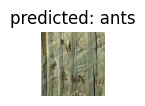

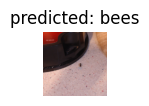

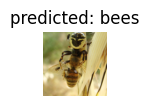

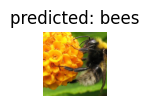

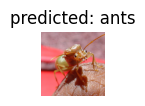

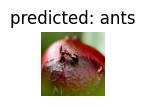

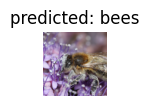

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


ANSWER 1


Data augmentation techniques like resize, crop, rotation, flipping, and color adjustments are crucial in training machine learning models, particularly in computer vision tasks. Here's why they are significant:

 1. Increased Robustness: Augmentations help create a more robust model by exposing it to a wider variety of data variations. For example, resizing or cropping images introduces variability in scale, while rotation and flipping introduce variability in orientation. This helps the model generalize better to unseen data and reduces overfitting.

 2.Increased Dataset Size: Augmentations effectively increase the size of the training dataset without collecting new data. By applying various transformations to the existing data, you effectively multiply the amount of training data available, which can help in training deep learning models more effectively, especially when data is limited.

 3. Reduced Overfitting: Overfitting occurs when a model learns to memorize the training data rather than generalizing patterns. Augmentations introduce noise and variability into the training data, which can prevent the model from overfitting by learning more generalizable features.

 4. Improved Generalization: By presenting the model with a diverse set of augmented data during training, it learns to focus on the invariant features of the data, rather than specific details that might be present in the original dataset only. This improves the model's ability to generalize to new, unseen data.

 5. Invariance Learning: Certain augmentations, such as rotation and flipping, help the model learn to be invariant to these transformations. For example, a cat is still a cat whether it's upright or upside down. By exposing the model to various transformations during training, it learns to recognize objects regardless of their orientation, position, or other variations.

 6. Better Training Stability: Augmentations can also help in achieving better training stability by reducing the risk of the model getting stuck in local minima. By providing more diverse training examples, the optimization process is less likely to converge prematurely.

 Data augmentations play a crucial role in training robust machine learning models by increasing dataset size, improving generalization, reducing overfitting, and helping the model learn invariant features. They are particularly important in scenarios where collecting large amounts of labeled data is impractical or expensive.





ANSWER 2

If you don't use a pre-trained ResNet model and instead train it from scratch on your dataset, the performance may vary depending on factors such as the size and diversity of your dataset, the complexity of the task, and the available computational resources. Training a deep neural network like ResNet from scratch typically requires a large amount of labeled data and substantial computational power.

Without pre-training, the model starts with random weights, and the optimization process involves updating these weights based on the gradients computed during training. This process can be more challenging compared to transfer learning with pre-trained weights because the model needs to learn meaningful representations from scratch, which can require more data and computational resources.

In general, training a deep neural network from scratch may lead to the following outcomes:

 1. Poor Performance: Without pre-training, the model might struggle to learn meaningful representations from the data, especially if the dataset is small or lacks diversity. This can result in poor performance on the task of interest.

 2. Overfitting: Training from scratch on a small dataset increases the risk of overfitting, where the model memorizes the training examples rather than learning generalizable patterns. Regularization techniques such as dropout and weight decay may be necessary to mitigate overfitting.

 3. Increased Training Time: Training a deep neural network from scratch typically requires more time and computational resources compared to transfer learning with pre-trained weights. This is because the model needs to learn representations layer by layer, starting from random initialization.

 4. Resource Intensive: Training from scratch may require access to powerful hardware such as GPUs or TPUs and longer training times compared to transfer learning. This can be a limiting factor, especially for researchers or practitioners with limited computational resources.

while training a ResNet model from scratch is feasible, it may not always be the most practical or effective approach, especially for tasks with limited data or computational resources. Transfer learning using pre-trained models is often preferred as it allows leveraging knowledge from large-scale datasets and can lead to faster convergence and better performance, especially in scenarios with limited data.

ANSWER 3

Using a pre-trained ResNet model on a dataset significantly different from the ants vs. bees dataset can still provide benefits, but the extent of those benefits depends on various factors:

 1.Task Similarity: If the pre-trained model was trained on a dataset with similar tasks or features as the ants vs. bees dataset (e.g., image classification tasks with natural images), then transfer learning can still be effective. The lower layers of the pre-trained model have likely learned general features like edges, textures, and shapes that are applicable to a wide range of visual recognition tasks.

2. Domain Shift: If there is a significant domain shift between the pre-training dataset and the target dataset (ants vs. bees), transfer learning may not work as effectively. A domain shift occurs when the statistical properties of the data in the target domain differ from those in the source domain. In such cases, features learned by the pre-trained model may not generalize well to the target domain, leading to suboptimal performance.

 3. Fine-Tuning and Adaptation: Fine-tuning the pre-trained model on the target dataset can help adapt its learned features to better suit the target domain. By updating the weights of the pre-trained model using the target dataset, the model can learn task-specific representations that improve performance on the ants vs. bees classification task.

 4. Amount of Data: The amount of data available for fine-tuning also plays a crucial role. If the target dataset is small, fine-tuning becomes more challenging, and there is a higher risk of overfitting to the target dataset. In such cases, techniques like data augmentation, regularization, and progressive unfreezing of layers can help improve performance.

while using a pre-trained ResNet model on a significantly different dataset can still provide a good starting point for transfer learning, the effectiveness of transfer learning depends on the similarity between the source and target domains, the availability of data, and the fine-tuning strategy employed. Experimentation and careful evaluation are necessary to determine the best approach for a specific task and dataset.